In [1]:
import glob
import numpy as np
import scipy.optimize as opt
import scipy.signal as sig
import scipy.special as sf
import matplotlib.pyplot as plt

In [2]:
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.right'] = True
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.grid'] = True

File names have a VILE format this time: `DD_MM_YYYY--hh-mm-ss`. Just part of the software we're using.

## Modulation Setting

We systematically examined the effect of the Auger analyzer "modulation" setting on spectra. Modulation is the baseline of the derivative essentially. Magnitude of lock-in amp output is linear with modulation up to a certain point for each peak. The max. modulation at which it is linear is approx. the width of the peak.

### At Auger Peak
This experiment's variables will be prefixed with `AM`

In [3]:
AM_runs = glob.glob("Runs/Modulation Effect Silver Auger/*.csv")
AM_exclude = ["15_04_2025--15-30-54.csv", "15_04_2025--16-11-02.csv"]

AM_n = len(AM_runs) - len(AM_exclude)

# Energy scale is the same for all runs.
AM_energies = np.zeros((AM_n, 126))
AM_returns = np.zeros_like(AM_energies)
AM_headers = []

i = 0
for r in AM_runs:
    if r.split("\\")[1] not in AM_exclude:
        with open(r) as f:
            header = f.readline().split()[1]
            AM_headers.append(header)
        AM_energies[i], AM_returns[i] = np.loadtxt(r, delimiter = ',', unpack = True)
        i += 1


AM_mean_returns = np.mean(AM_returns, -1)

In [4]:
# Find Offsets
AM_offsets = np.zeros(AM_n)

for j in range(AM_n):
    ret = AM_returns[j]
    indices = range(126)
    F = lambda i, O: np.interp(i + O, indices, ret)
    P, _ = opt.curve_fit(F, indices, AM_returns[1], p0 = (1,))
    AM_offsets[j] = round(P[0])

C:\Users\Martin McIntosh\AppData\Local\Temp\ipykernel_7700\2174674809.py:8: OptimizeWarning: Covariance of the parameters could not be estimated
  P, _ = opt.curve_fit(F, indices, AM_returns[1], p0 = (1,))


In [5]:
F = lambda x, m, b: m * x + b
P, cov = opt.curve_fit(F, [20, 15, 10, 8, 6], -AM_offsets)
print(f"{P[0]:.2f} pm {np.sqrt(cov[0,0]):.2f}")

0.36 pm 0.04


In [6]:
AM_principal_magnitudes = np.zeros(AM_n)
for j in range(AM_n):
    antipeaks, info = sig.find_peaks(-AM_returns[j], prominence = 0.0)
    AM_principal_magnitudes[j] = max(info['prominences'])

In [7]:
# Manually correcting identification of the wrong peak for the 4eV signal.
AM_principal_magnitudes[-1] = (info['prominences'])[np.argmax(info['prominences']) - 1]

In [8]:
AM_noise_window = (60, 75)
AM_noise_std = np.std(AM_returns[:,AM_noise_window[0]:AM_noise_window[1]], axis = -1)

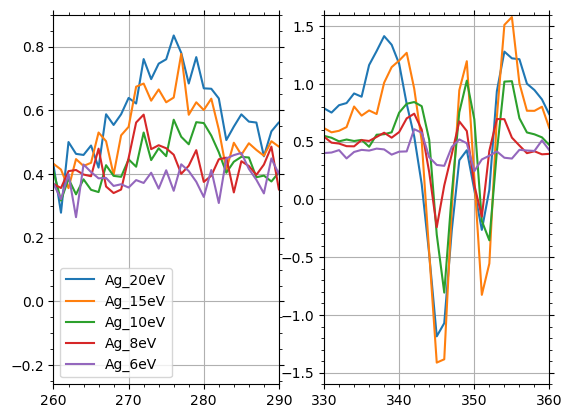

In [9]:
plt.subplot(1, 2, 2)
plt.plot(AM_energies.T - AM_offsets, AM_returns.T, label = AM_headers)
plt.xlim(330,360)
plt.ylim(-1.6, 1.6)
plt.subplot(1, 2, 1)
plt.plot(AM_energies.T - AM_offsets, AM_returns.T, label = AM_headers)
plt.xlim(260,290)
plt.ylim(-0.26, 0.9)
plt.legend()

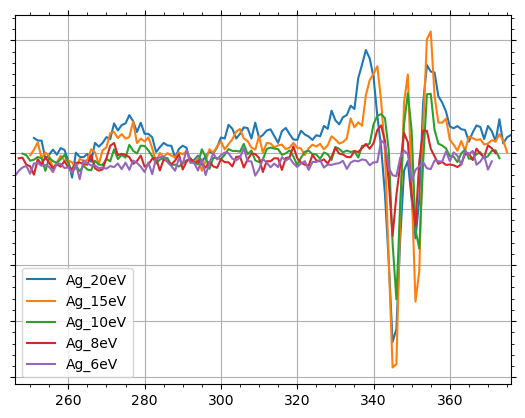

In [10]:
plt.plot(AM_energies.T - AM_offsets, AM_returns.T, label = AM_headers)
plt.legend()
plt.yticks(np.arange(-1.5, 1.6, 0.5), np.full(7, ""));

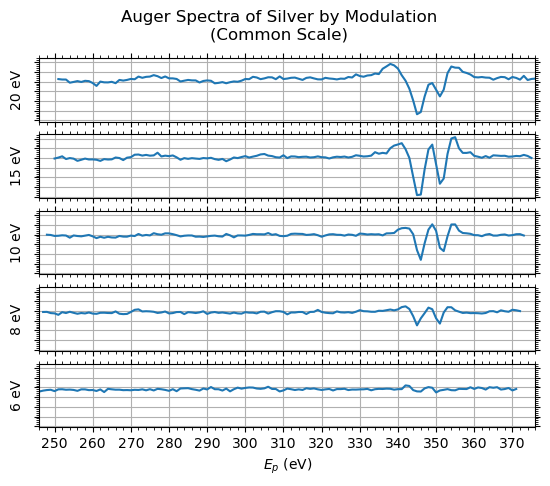

In [11]:
plt.subplots(5, 1, sharex = True, sharey = True)
plt.yticks(np.arange(-1.5, 1.6, 0.5), np.full(7, ""))
plt.xticks(np.arange(250,375, 10))
for i in range(AM_n):
    plt.subplot(5, 1, i + 1)
    plt.plot(AM_energies[i] - AM_offsets[i], AM_returns[i])
    # this is an atrocity
    label = AM_headers[i][3]
    if AM_headers[i][4] != 'e':
        label += AM_headers[i][4]
        
    plt.ylabel(label + " eV")

plt.xlabel("$E_p$ (eV)")
plt.suptitle("Auger Spectra of Silver by Modulation\n(Common Scale)")
plt.savefig("AM_5spectra.png")

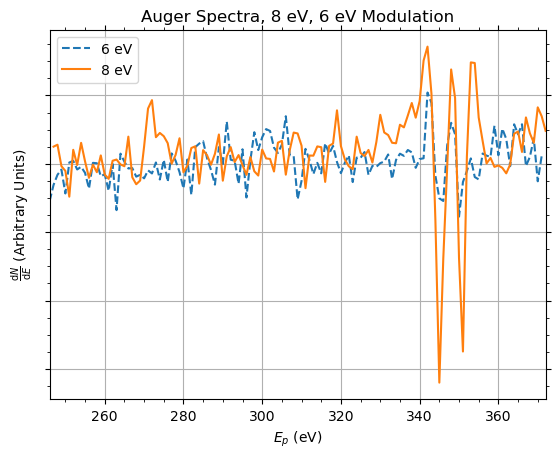

In [12]:
plt.plot(AM_energies[-1] - AM_offsets[-1], AM_returns[-1], '--', label = "6 eV")
plt.plot(AM_energies[-2] - AM_offsets[-2], AM_returns[-2], label = "8 eV")
plt.yticks(np.arange(-0.2, 0.61, 0.2), np.full(5, ""))
plt.legend()
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.title("Auger Spectra, 8 eV, 6 eV Modulation")
plt.savefig("AM_2spectra.png")

### At Elastic Peak
More or less the same procedure as before but with different data.
This experiment's variables will be prefixed with `EM`

In [13]:
EM_runs = glob.glob("Runs/Modulation Effect Silver Elastic/*.csv")
EM_exclude = ["15_04_2025--15-06-29.csv", "15_04_2025--15-21-25.csv"]

EM_n = len(EM_runs) - len(EM_exclude)
EM_l = 71

# Energy scale is the same for all runs.
EM_energies = np.zeros((EM_n, EM_l))
EM_returns = np.zeros_like(EM_energies)
EM_headers = []

i = 0
for r in EM_runs:
    if r.split("\\")[1] not in EM_exclude:
        with open(r) as f:
            header = f.readline().split()[1]
            EM_headers.append(header)
        EM_energies[i], EM_returns[i] = np.loadtxt(r, delimiter = ',', unpack = True)
        i += 1


EM_mean_returns = np.mean(EM_returns, -1)

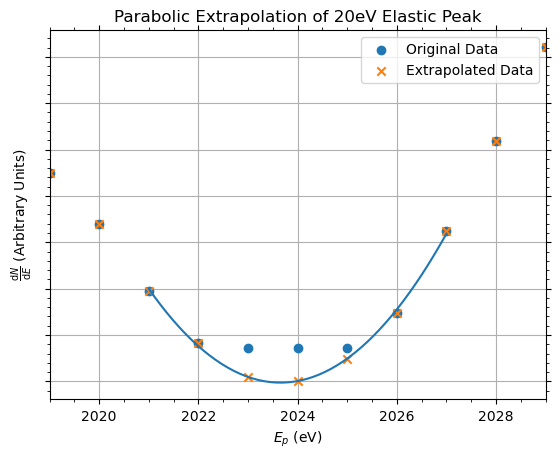

In [14]:
# The 20 ev Run was clipped at -5.2895...
# I will replace this with a quadratic extrapolation.
EM_slice = (EM_returns[0] > -5.288)[41:48]
x = (EM_energies[0][41:48])[EM_slice]
y = (EM_returns[0][41:48])[EM_slice]

# fit a quadratic polynomial
terms = np.polyfit(x,y,2)

EM_extrapolated = np.copy(EM_returns)
EM_extrapolated[0][43:46] = np.polyval(terms, EM_energies[0][43:46])

x = np.linspace(2021, 2027)


plt.scatter(EM_energies[0][39:50], EM_returns[0][39:50], label = "Original Data")
plt.scatter(EM_energies[0][39:50], EM_extrapolated[0][39:50], marker = 'x', label = "Extrapolated Data")
plt.plot(x, np.polyval(terms, x))
plt.yticks(np.arange(-6, 1.1, 1), np.full(8, ""))
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.title("Parabolic Extrapolation of 20eV Elastic Peak")
plt.legend()
plt.savefig("EM_extrapolation.png")

In [15]:
# Find Offsets
EM_offsets = np.zeros(EM_n)

for j in range(EM_n):
    ret = EM_extrapolated[j]
    indices = range(EM_l)
    F = lambda i, O: np.interp(i + O, indices, ret)
    P, _ = opt.curve_fit(F, indices, EM_extrapolated[1], p0 = (0,))
    EM_offsets[j] = P[0]

EM_offsets[-2:] = [0, 0]

In [16]:
EM_principal_magnitudes = np.zeros(EM_n)
for j in range(EM_n):
    antipeaks, info = sig.find_peaks(-EM_extrapolated[j], prominence = 0.0)
    EM_principal_magnitudes[j] = max(info['prominences'])

In [17]:
EM_noise_window = (0, 10)
EM_noise_std = np.std(EM_returns[:,EM_noise_window[0]:EM_noise_window[1]], axis = -1)

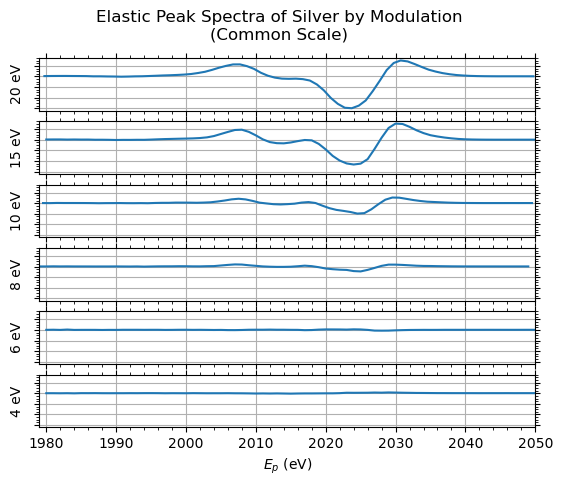

In [18]:
plt.subplots(6, 1, sharex = True, sharey = True)
plt.yticks(np.arange(-6, 4.1, 2), np.full(6, ""))
for i in range(EM_n):
    plt.subplot(6, 1, i + 1)
    plt.plot(EM_energies[i] - EM_offsets[i], EM_extrapolated[i])
    # this is an atrocity
    label = EM_headers[i][9]
    if EM_headers[i][10] != 'e':
        label += EM_headers[i][10]
        
    plt.ylabel(label + " eV")

plt.xlabel("$E_p$ (eV)")

plt.suptitle("Elastic Peak Spectra of Silver by Modulation\n(Common Scale)")
plt.savefig("EM_6spectra.png")

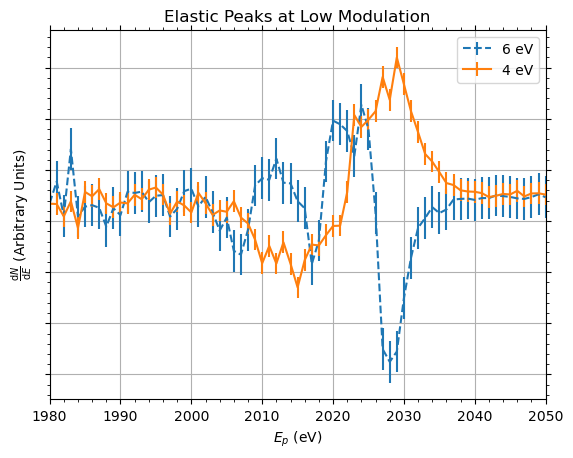

In [19]:
plt.errorbar(EM_energies[-2], EM_extrapolated[-2], yerr = EM_noise_std[-2], fmt = '--', label = "6 eV")
plt.errorbar(EM_energies[-1], EM_extrapolated[-1], yerr = EM_noise_std[-1], label = "4 eV")
plt.yticks(np.arange(-0.15, 0.16, 0.05), np.full(7, ""))
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.title("Elastic Peaks at Low Modulation")
plt.legend()
plt.savefig("EM_lowmod.png")

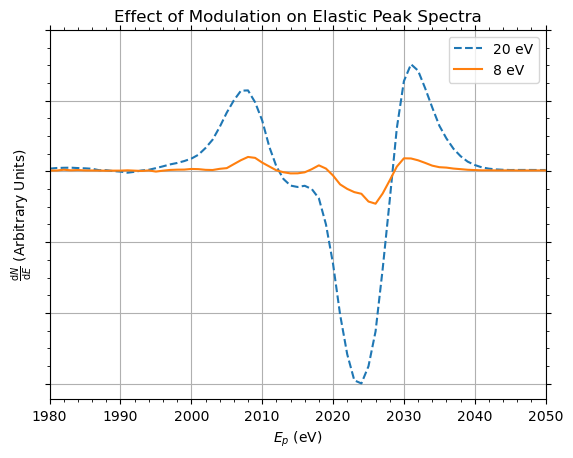

In [20]:
plt.plot(EM_energies[0], EM_extrapolated[0],'--', label = "20 eV")
plt.plot(EM_energies[3], EM_extrapolated[3], label = "8 eV")
plt.yticks(np.arange(-6, 4.1, 2), np.full(6, ""))
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.title("Effect of Modulation on Elastic Peak Spectra")
plt.legend()
plt.savefig("EM_2spectra.png")

## Comparisons

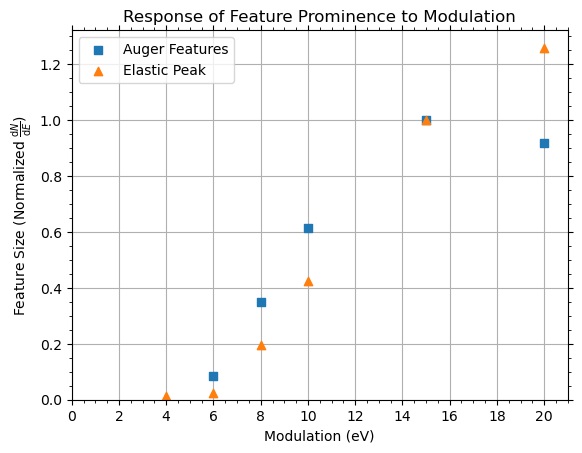

In [21]:
plt.scatter([20, 15, 10, 8, 6], AM_principal_magnitudes / AM_principal_magnitudes[1], marker = 's', label = "Auger Features")
plt.scatter([20, 15, 10, 8, 6, 4], EM_principal_magnitudes / EM_principal_magnitudes[1], marker = '^', label = "Elastic Peak")
plt.xlim([0,21])
plt.legend()
plt.ylim(bottom = 0)
plt.xticks(np.arange(0,21,2));
plt.title("Response of Feature Prominence to Modulation")
plt.ylabel(r"Feature Size (Normalized $\frac{\mathrm{d}N}{\mathrm{d}E}$)")
plt.xlabel("Modulation (eV)")
plt.savefig("compare_prominence.png")

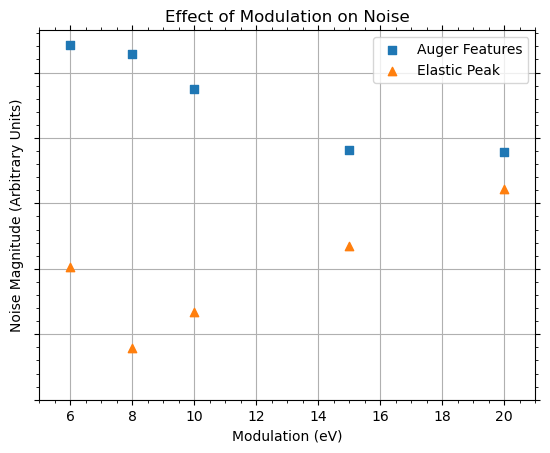

In [22]:
plt.scatter([20, 15, 10, 8, 6], AM_noise_std, marker = 's', label = "Auger Features")
plt.scatter([20, 15, 10, 8, 6, 4], EM_noise_std, marker = '^', label = "Elastic Peak")
plt.ylim(bottom = 0)
plt.yticks(np.arange(0, 0.051, 0.01), np.full(6, ""))
plt.xlim(5, 21)
plt.legend()
plt.title("Effect of Modulation on Noise")
plt.xlabel("Modulation (eV)")
plt.ylabel(r"Noise Magnitude (Arbitrary Units)")
plt.savefig("compare_noise.png")

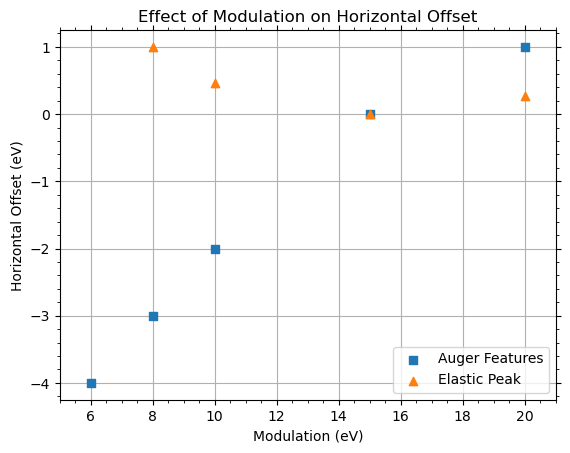

In [23]:
plt.scatter([20, 15, 10, 8, 6], -AM_offsets, marker = 's', label = "Auger Features")
plt.scatter([20, 15, 10, 8], EM_offsets[:-2], marker = '^', label = "Elastic Peak")
plt.xlim(5, 21)
plt.legend()
plt.xlabel("Modulation (eV)")
plt.ylabel("Horizontal Offset (eV)")
plt.title("Effect of Modulation on Horizontal Offset")
plt.savefig("compare_offset.png")

## Study of the Luminous Spot
We found a point on the carousel which glowed brigthly when the electron beam landed on it. This point of light was brighter and more distinct than even the Calcium Tungstate scintillator. It is likely copper oxide from the copper sample clips (Chottiner via Monreal). We want to see if we can independently determine its composition.

This experiment's variables will be prefixed with `LS`

In [24]:
LS_spot_run = "Runs/Spot/17_04_2025--14-34-53.csv"
LS_carousel_run = "Runs/Carousel/17_04_2025--14-50-48.csv"


LS_energies = np.arange(1001)
_, LS_spot_returns = np.loadtxt(LS_spot_run, delimiter = ',', unpack = True)
_, LS_carousel_returns = np.loadtxt(LS_carousel_run, delimiter = ',', unpack = True)

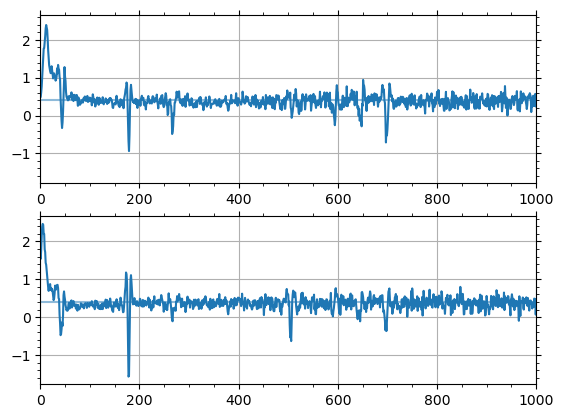

In [25]:
plt.subplot(2,1,1)
plt.plot(LS_energies, LS_carousel_returns)
plt.axhline(0.4, alpha = 0.5)
plt.subplot(2,1,2, sharex = plt.gca(), sharey = plt.gca())
scale = 1.10
plt.plot(LS_energies, LS_spot_returns * scale)
plt.axhline(0.4, alpha = 0.5)

In [26]:
LS_diff = LS_carousel_returns - LS_spot_returns * scale
LS_boxcar_param = 2
LS_boxcar_size = 2 * LS_boxcar_param + 1
LS_diff_smooth = sig.convolve(LS_diff, np.full(LS_boxcar_size, 1/LS_boxcar_size))

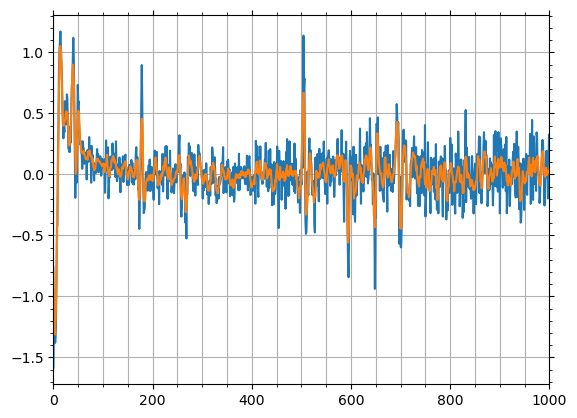

In [27]:
plt.plot(LS_energies, LS_diff)
plt.plot(LS_energies, LS_diff_smooth[LS_boxcar_param:-LS_boxcar_param])
plt.grid(which="minor", axis = "x")

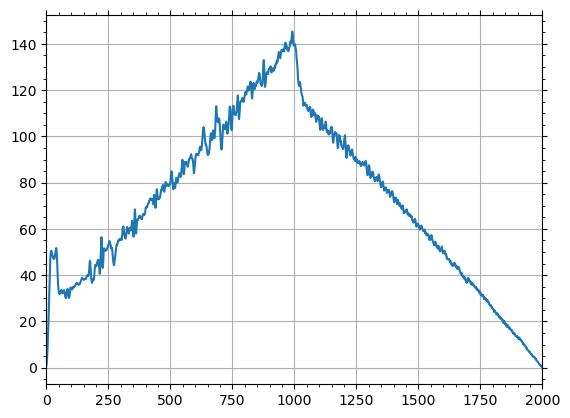

In [28]:
plt.plot(sig.convolve(LS_carousel_returns, LS_spot_returns))

### Tentative Conclusion
Peaks at around 600, 650, 700 eV are characteristic of iron. These peaks have shifted slightly between samples, which may mean the iron is in a different chemical configuration. Additionally a peak around 500 eV is greatly enhanced in the spectrum of the luminous spot. Referencing the handbook, this peak is probably due to oxygen. Therefore, the luminous spot is probably mostly made of iron oxide.

No signs of copper or beryllium (the clip materials).

Peaks around 270 could be carbon, while the peak just below 600 could be partially or mainly due to chromium. These are both key alloying elements in stainless steel. Chromium also has a peak at about 529 (just above oxygen) which is modestly evident.

## Elastic Peak: Ratecounter

This experiment will be tagged with `AgRC`

In [29]:
AgRC_run = "Runs/Ag Counts Elastic Peak/22_04_2025--14-43-15.csv"

AgRC_energies, AgRC_return = np.loadtxt(AgRC_run, delimiter = ',', unpack = True)

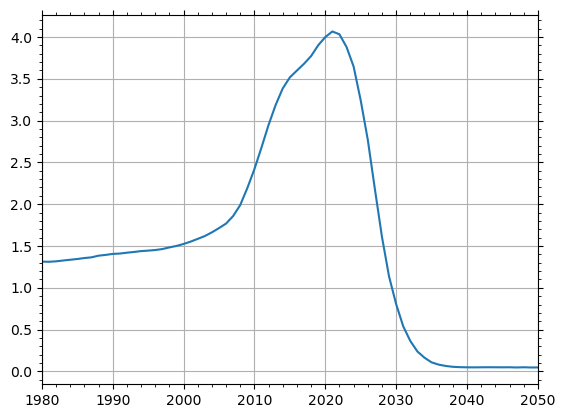

In [30]:
plt.plot(AgRC_energies, AgRC_return)

In [31]:
AgRC_centerdiff = AgRC_return[2:] - AgRC_return[:-2]
AgRC_centerdiff15 = AgRC_return[15:] - AgRC_return[:-15]
AgRC_15eVgauss = sig.convolve(AgRC_centerdiff, np.full(15, 1/15))

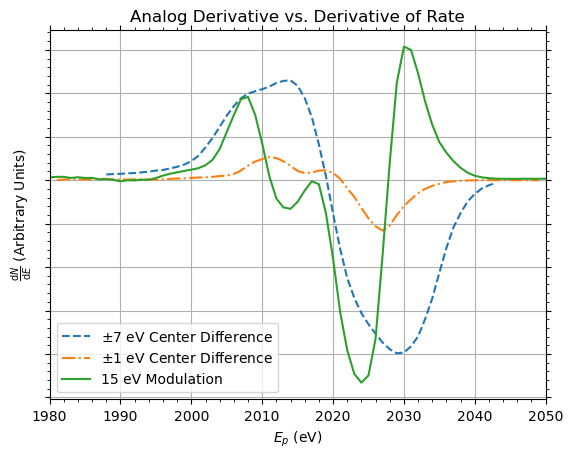

In [32]:
# The Ratecounter and Derivative runs here both used 15eV modulation.
plt.plot(AgRC_energies[8:-7], AgRC_centerdiff15, '--', label = r"$\pm 7$ eV Center Difference")
plt.plot(AgRC_energies[1:-1], AgRC_centerdiff, '-.', label = r"$\pm 1$ eV Center Difference")
plt.plot(EM_energies[1], EM_returns[1], label = "15 eV Modulation")
plt.yticks(np.arange(-5, 4, 1), np.full(9, ""))
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.legend()
plt.title("Analog Derivative vs. Derivative of Rate")
plt.savefig("modes_compared.png")

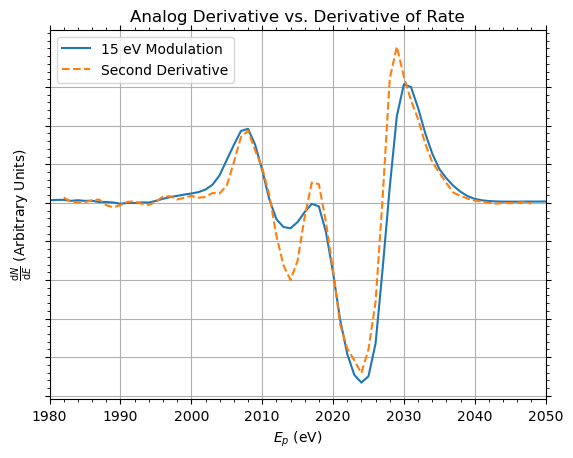

In [33]:
AgRC_dd = AgRC_centerdiff[2:] - AgRC_centerdiff[:-2]

plt.plot(EM_energies[1], EM_returns[1], label = "15 eV Modulation")
plt.plot(AgRC_energies[2:-2], AgRC_dd * 9, '--', label = "Second Derivative")
plt.yticks(np.arange(-5, 4, 1), np.full(9, ""))
plt.xlabel("$E_p$ (eV)")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$ (Arbitrary Units)")
plt.legend()
plt.title("Analog Derivative vs. Derivative of Rate")
plt.savefig("modes_2D.png")

## Time Constant Effect

In [34]:
TC1_runs = ["Runs/Silver/10_04_2025--14-54-55.csv",
          "Runs/Silver/10_04_2025--14-58-23.csv",
          "Runs/Silver/10_04_2025--15-06-04.csv",]

TC1_TCs = [30, 3, 0.3]

TC1_energies = np.zeros((3, 21))
TC1_returns = np.zeros((3, 21))

i = 0
for r in TC1_runs:
    TC1_energies[i], TC1_returns[i] = np.loadtxt(r, delimiter = ',', unpack = True)
    i += 1



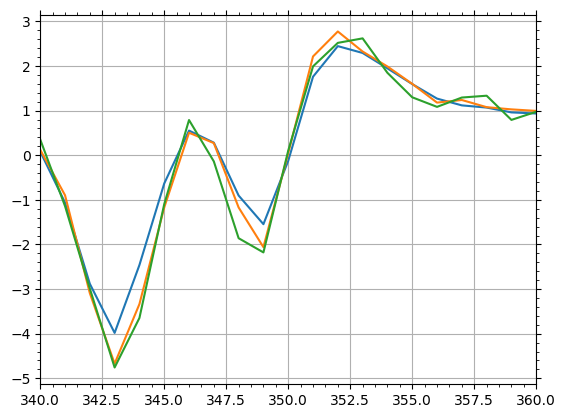

In [35]:
plt.plot(TC1_energies.T, TC1_returns.T)

In [36]:
TC2_runs = ["Runs/Modulation Effect Silver Elastic/15_04_2025--14-58-12.csv",
            "Runs/Modulation Effect Silver Elastic/15_04_2025--15-06-29.csv",
            "Runs/Modulation Effect Silver Elastic/15_04_2025--15-13-02.csv",
            "Runs/Modulation Effect Silver Elastic/15_04_2025--15-21-25.csv",]

TC3_runs = ["Runs/Modulation Effect Silver Auger/15_04_2025--15-57-21.csv",
            "Runs/Modulation Effect Silver Auger/15_04_2025--16-11-02.csv",]

TC2_energies = np.zeros((4, 71))
TC2_returns = np.zeros((4, 71))

TC3_energies = np.zeros((2,126))
TC3_returns = np.zeros((2,126))

i = 0
for r in TC2_runs:
    TC2_energies[i], TC2_returns[i] = np.loadtxt(r, delimiter = ',', unpack = True)
    i += 1

i = 0
for r in TC3_runs:
    TC3_energies[i], TC3_returns[i] = np.loadtxt(r, delimiter = ',', unpack = True)
    i += 1

In [37]:
TC2_noise_window = (0, 10)
TC2_noise_std = np.std(TC2_returns[:,TC2_noise_window[0]:TC2_noise_window[1]], axis = -1)
print(TC2_noise_std)
print(1 - TC2_noise_std[1::2]/TC2_noise_std[0::2])

TC3_noise_window = (60, 75)
TC3_noise_std = np.std(TC3_returns[:,TC3_noise_window[0]:TC3_noise_window[1]], axis = -1)
print(TC3_noise_std)
print(1 - TC3_noise_std[1]/TC3_noise_std[0])

[0.02034951 0.0080567  0.01057935 0.00482031]
[0.60408392 0.54436596]
[0.0541645 0.0275794]
0.49082141142348


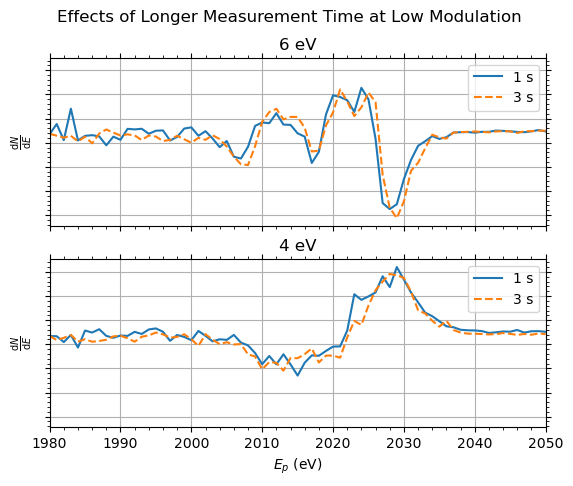

In [38]:
plt.subplots(nrows = 2, ncols = 1, sharex = True, sharey = True)
plt.yticks(np.arange(-0.15, 0.16, 0.05), np.full(7, ""))
plt.subplot(211)
plt.plot(TC2_energies[0], TC2_returns[0].T, label = "1 s")
plt.plot(TC2_energies[1], TC2_returns[1].T, ls = "--", label = "3 s")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$")
plt.title("6 eV")
plt.legend()
plt.subplot(212)
plt.plot(TC2_energies[2], TC2_returns[2].T, label = "1 s")
plt.plot(TC2_energies[3], TC2_returns[3].T, ls = "--", label = "3 s")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$")
plt.xlabel("$E_p$ (eV)")
plt.title("4 eV")
plt.legend()
plt.suptitle("Effects of Longer Measurement Time at Low Modulation")
plt.savefig("TC_compare.png")

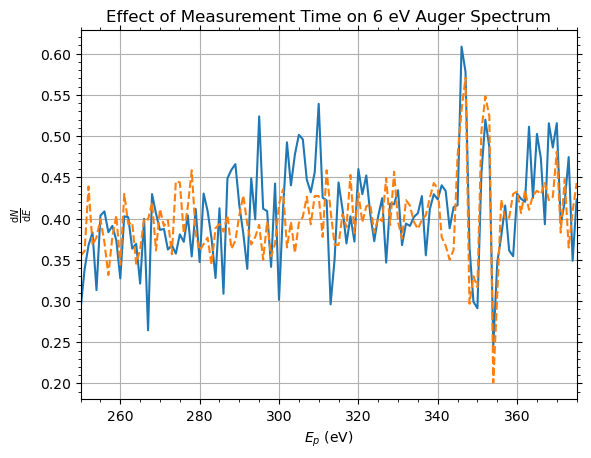

In [39]:
plt.plot(TC3_energies[0], TC3_returns[0], label = "1 s")
plt.plot(TC3_energies[1], TC3_returns[1], ls = "--", label = "3 s")
plt.ylabel(r"$\frac{\mathrm{d}N}{\mathrm{d}E}$")
plt.xlabel("$E_p$ (eV)")
plt.title("Effect of Measurement Time on 6 eV Auger Spectrum")
plt.savefig("TC_auger.png")